In [1]:
# FIRST CELL — upload jd.csv and resume.csv manually from your PC

import pandas as pd
from google.colab import files

print("Upload jd.csv")
uploaded_jd = files.upload()
jd_path = list(uploaded_jd.keys())[0]

print("Upload resume.csv")
uploaded_resume = files.upload()
resume_path = list(uploaded_resume.keys())[0]

jd = pd.read_csv(jd_path, low_memory=False)
resume = pd.read_csv(resume_path, low_memory=False)

print("JD shape:", jd.shape)
print("Resume shape:", resume.shape)

display(jd.head(2))
display(resume.head(2))


Upload jd.csv


Saving jd.csv to jd.csv
Upload resume.csv


Saving Resume.csv to Resume.csv
JD shape: (25740, 2)
Resume shape: (2484, 4)


,Unnamed: 0,desc
0,0,"['ameria', 'investment', 'consulting', 'compan..."
1,1,"['international', 'research', 'exchanges', 'bo..."


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR


In [2]:
# CELL 2 — install + imports + basic cleaning functions

!pip -q install nltk spacy sentence-transformers transformers

import pandas as pd
import numpy as np
import re
import nltk
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemm = WordNetLemmatizer()

def clean_text(t):
    if not isinstance(t, str):
        return ""
    t = t.lower()
    t = re.sub(r'[^a-z0-9 ]+', ' ', t)
    tokens = [lemm.lemmatize(w) for w in t.split() if w not in stop_words and len(w) > 2]
    return " ".join(tokens)

print("Setup complete.")


Setup complete.


In [3]:
# CELL 3 — cleaning, skill extraction, pairing resumes with JDs, creating labels

import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

# --- CLEAN TEXT ---
resume['clean_text'] = resume['Resume_str'].fillna("").progress_apply(clean_text)
jd['clean_text'] = jd['desc'].fillna("").progress_apply(clean_text)

# --- BASIC SKILL LIST (expandable) ---
skill_list = [
    'python','java','c++','c','javascript','typescript','react','node','django','flask',
    'html','css','sql','mysql','postgresql','mongodb','nlp','ml','ai','deep learning',
    'tensorflow','pytorch','aws','azure','docker','kubernetes','git','jira','excel',
    'communication','leadership','marketing','sales','analysis','management','design'
]

def extract_skills(text):
    tokens = set(text.split())
    return list(set([s for s in skill_list if s in tokens]))

resume['skills'] = resume['clean_text'].apply(extract_skills)
jd['skills'] = jd['clean_text'].apply(extract_skills)

# --- CREATE PAIRED DATASET ---
# For efficiency, randomly pair each resume with 3 job descriptions
pairs = []
for idx, r in resume.iterrows():
    sampled_jd = jd.sample(3, replace=True, random_state=idx)
    for _, j in sampled_jd.iterrows():
        pairs.append([
            r['clean_text'],
            j['clean_text'],
            r['skills'],
            j['skills']
        ])

df = pd.DataFrame(pairs, columns=['resume_text', 'jd_text', 'resume_skills', 'jd_skills'])


# --- INITIAL LABEL GENERATION (SUPERVISED LEARNING)
# Using Jaccard skill similarity + text length similarity as initial weak label
def jaccard(a, b):
    A, B = set(a), set(b)
    if len(A) == 0 and len(B) == 0:
        return 0
    return len(A & B) / len(A | B)

def weak_label(row):
    js = jaccard(row.resume_skills, row.jd_skills)
    tl = min(len(row.resume_text), len(row.jd_text)) / max(len(row.resume_text), len(row.jd_text)+1)
    score = 0.7*js + 0.3*tl
    return score

df['match_score'] = df.progress_apply(weak_label, axis=1)
df['match_label'] = pd.cut(df['match_score'], bins=[0,0.33,0.66,1.0], labels=[0,1,2]).astype(int)

print("Pairs created:", df.shape)
df.head()


100%|██████████| 7452/7452 [00:00<00:00, 42005.44it/s]


ValueError: Cannot convert float NaN to integer

In [4]:
# FIX LABEL GENERATION — safer bins, drop NaN, convert cleanly

# Clip values to valid range
df['match_score'] = df['match_score'].clip(0, 0.9999)

# Do binning safely
df['match_label'] = pd.cut(
    df['match_score'],
    bins=[0, 0.33, 0.66, 1.0],
    labels=[0, 1, 2],
    include_lowest=True
)

# Fill any possible NaN with "1" (medium match)
df['match_label'] = df['match_label'].fillna(1).astype(int)

print("Labels fixed. Distribution:")
print(df['match_label'].value_counts())


Labels fixed. Distribution:
match_label
0    5379
1    1901
2     172
Name: count, dtype: int64


In [5]:
# CELL 4 — GPU optimized, batch embeddings + MLP classifier

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neural_network import MLPClassifier
import numpy as np
from tqdm import tqdm
import joblib

# Load BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')

# --- BATCH ENCODING FUNCTION ---
def batch_encode(texts, model, batch_size=500):
    embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding"):
        batch = texts[i:i+batch_size]
        emb = model.encode(batch, show_progress_bar=False)
        embeddings.append(emb)
    return np.vstack(embeddings)

# Encode resume and JD text separately
resume_emb = batch_encode(df['resume_text'].tolist(), model)
jd_emb = batch_encode(df['jd_text'].tolist(), model)

# Combine embeddings
X = np.hstack([resume_emb, jd_emb])
y = df['match_label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# MLP classifier
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=20,
    batch_size=64,
    verbose=True,
    random_state=42
)

# Train model
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)
print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

# Save model
joblib.dump(clf, 'resume_jd_match_model.pkl')
np.save("resume_emb_dim.npy", np.array([resume_emb.shape[1]]))
print("\nModel saved: resume_jd_match_model.pkl")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Encoding: 100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Iteration 1, loss = 0.59621134
Iteration 2, loss = 0.50123209
Iteration 3, loss = 0.49154056
Iteration 4, loss = 0.47726255
Iteration 5, loss = 0.45988323
Iteration 6, loss = 0.45173147
Iteration 7, loss = 0.42573087
Iteration 8, loss = 0.41375258
Iteration 9, loss = 0.39304772
Iteration 10, loss = 0.36148414
Iteration 11, loss = 0.34065375
Iteration 12, loss = 0.30391118
Iteration 13, loss = 0.26236611
Iteration 14, loss = 0.23726334
Iteration 15, loss = 0.19625049
Iteration 16, loss = 0.15781745
Iteration 17, loss = 0.14371903
Iteration 18, loss = 0.09500647
Iteration 19, loss = 0.07115211
Iteration 20, loss = 0.05463052

Accuracy: 0.7317236753856472

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1076
           1       0.50      0.62      0.56       380
           2       0.17      0.14      0.15        35

    accuracy                           0.73      1491
   macro avg       0.51      0.52      0.5

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


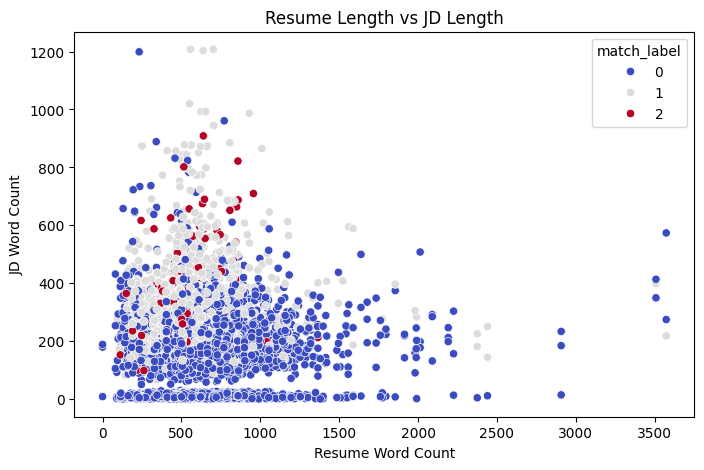

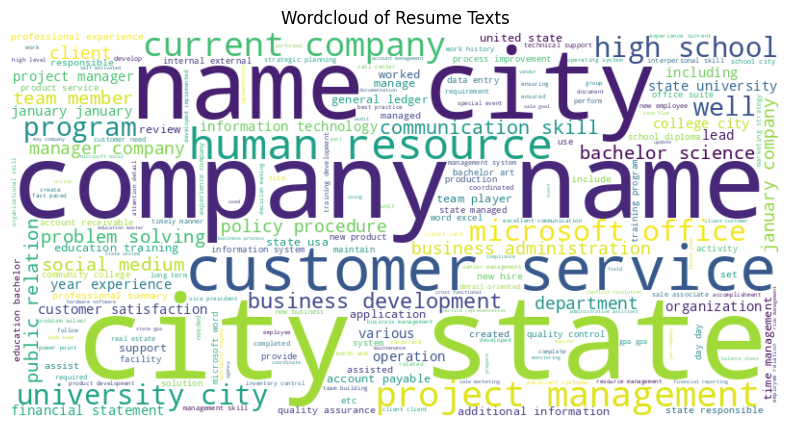

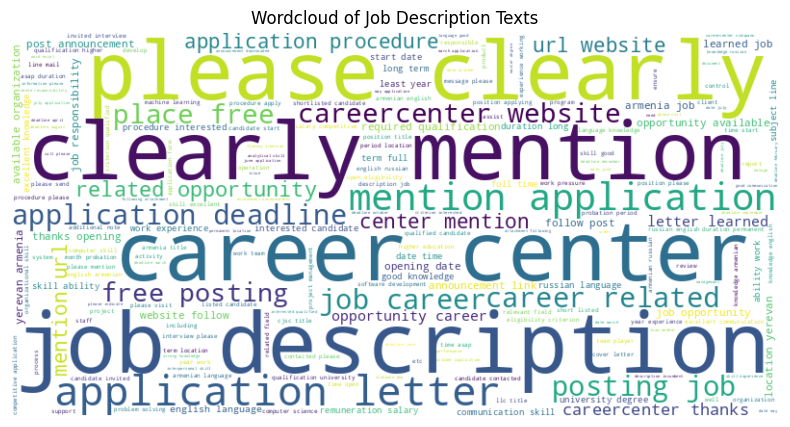

/tmp/ipython-input-3447746977.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[k for k,v in Counter(all_resume_skills).most_common(15)],


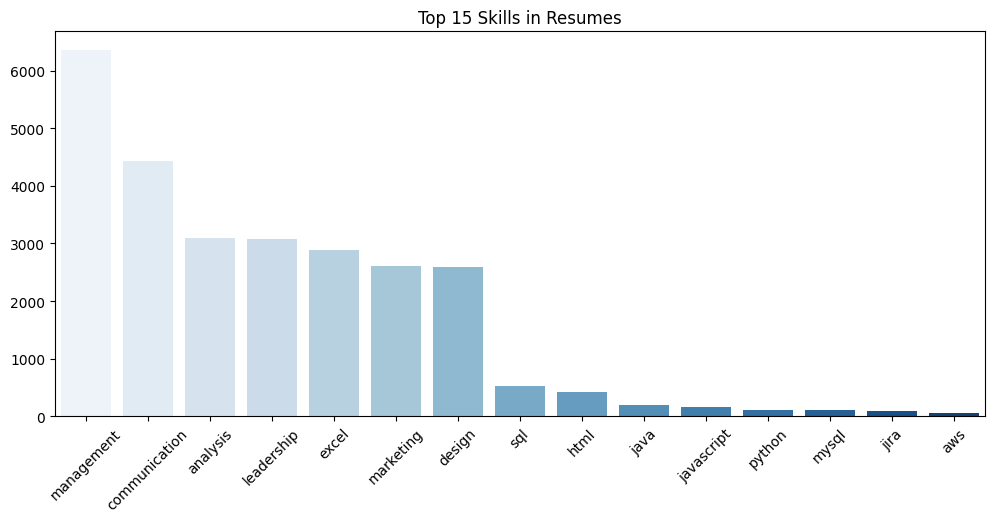

/tmp/ipython-input-3447746977.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[k for k,v in Counter(all_jd_skills).most_common(15)],


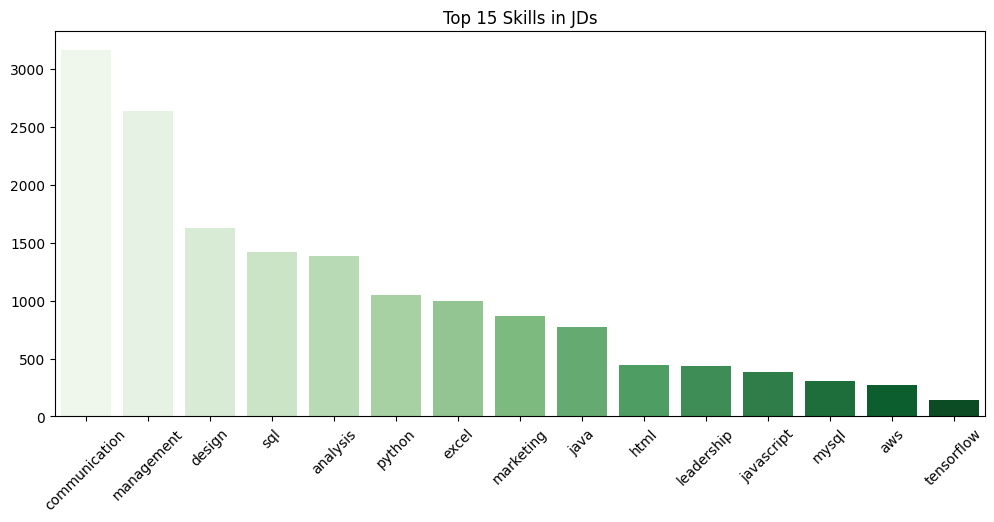

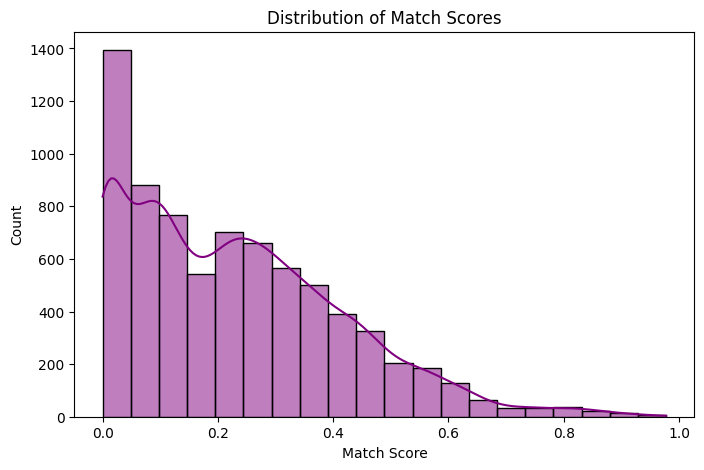

In [6]:
# CELL — Exploratory Data Analysis (EDA)
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

# Resume length vs JD length
df['resume_len'] = df['resume_text'].apply(lambda x: len(x.split()))
df['jd_len'] = df['jd_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.scatterplot(x='resume_len', y='jd_len', data=df, hue='match_label', palette='coolwarm')
plt.title('Resume Length vs JD Length')
plt.xlabel('Resume Word Count')
plt.ylabel('JD Word Count')
plt.show()

# Wordcloud for resumes
all_resume_text = " ".join(df['resume_text'].tolist())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_resume_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Resume Texts')
plt.show()

# Wordcloud for JDs
all_jd_text = " ".join(df['jd_text'].tolist())
wc = WordCloud(width=800, height=400, background_color='white').generate(all_jd_text)
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud of Job Description Texts')
plt.show()

# Skill distribution
all_resume_skills = sum(df['resume_skills'].tolist(), [])
all_jd_skills = sum(df['jd_skills'].tolist(), [])

plt.figure(figsize=(12,5))
sns.barplot(x=[k for k,v in Counter(all_resume_skills).most_common(15)],
            y=[v for k,v in Counter(all_resume_skills).most_common(15)], palette='Blues')
plt.title('Top 15 Skills in Resumes')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(x=[k for k,v in Counter(all_jd_skills).most_common(15)],
            y=[v for k,v in Counter(all_jd_skills).most_common(15)], palette='Greens')
plt.title('Top 15 Skills in JDs')
plt.xticks(rotation=45)
plt.show()

# Match Score distribution
plt.figure(figsize=(8,5))
sns.histplot(df['match_score'], bins=20, kde=True, color='purple')
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.show()


In [7]:
# CELL 5 — Inference Function
import joblib
import numpy as np

# Load model
clf = joblib.load('resume_jd_match_model.pkl')
resume_dim = int(np.load("resume_emb_dim.npy"))

# Load BERT again
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

def extract_skills(text):
    tokens = set(text.lower().split())
    skills = [
        'python','java','c++','c','javascript','typescript','react','node','django','flask',
        'html','css','sql','mysql','postgresql','mongodb','nlp','ml','ai','deep learning',
        'tensorflow','pytorch','aws','azure','docker','kubernetes','git','jira','excel',
        'communication','leadership','marketing','sales','analysis','management','design'
    ]
    return list(set([s for s in skills if s in tokens]))

def predict_resume_jd(resume_text, jd_text):
    # Clean text
    def clean(t):
        import re
        from nltk.stem import WordNetLemmatizer
        from nltk.corpus import stopwords
        lemm = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        t = t.lower()
        t = re.sub(r'[^a-z0-9 ]+', ' ', t)
        tokens = [lemm.lemmatize(w) for w in t.split() if w not in stop_words and len(w)>2]
        return " ".join(tokens)

    resume_clean = clean(resume_text)
    jd_clean = clean(jd_text)

    # Encode embeddings
    resume_emb = model.encode([resume_clean])
    jd_emb = model.encode([jd_clean])
    X_input = np.hstack([resume_emb, jd_emb])

    # Predict label
    pred_label = clf.predict(X_input)[0]

    # Weak match score (0–100)
    resume_sk = extract_skills(resume_clean)
    jd_sk = extract_skills(jd_clean)
    matching_sk = list(set(resume_sk) & set(jd_sk))
    missing_sk = list(set(jd_sk) - set(resume_sk))
    match_score = int((len(matching_sk) / max(1,len(jd_sk)))*100)

    suitability = "Yes" if pred_label>=1 else "No"

    return {
        "Match Score (%)": match_score,
        "Matching Skills": matching_sk,
        "Missing Skills": missing_sk,
        "Suitability": suitability
    }

# Example usage
example_resume = resume['Resume_str'].iloc[0]
example_jd = jd['desc'].iloc[0]

result = predict_resume_jd(example_resume, example_jd)
print(result)


/tmp/ipython-input-2625956407.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  resume_dim = int(np.load("resume_emb_dim.npy"))


{'Match Score (%)': 80, 'Matching Skills': ['analysis', 'design', 'leadership', 'management'], 'Missing Skills': ['communication'], 'Suitability': 'Yes'}


In [8]:
from google.colab import files

# Download model
files.download('resume_jd_match_model.pkl')

# Download embedding dimension file
files.download('resume_emb_dim.npy')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>